In [1]:
__author__ = 'Brad'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
#import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.decomposition import PCA
from sklearn import svm

%matplotlib inline

In [142]:
# The competition datafiles are in the directory ../input
# Read competition data files:
train = pd.read_csv("../input/train.csv")
test  = pd.read_csv("../input/test.csv")

train_x = train.values[:,1:]
train_y = train.values[:,0]
test_x = test.values

print train_x

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


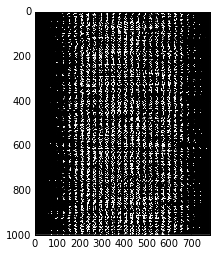

In [3]:
# plot the whole data array

#fig = plt.figure(1, (5., 5.))
plt.imshow(train_x[1:1000], cmap = cm.Greys_r, interpolation='none')
plt.grid(False)

let's take a look at one of the training examples. 
To do that, I'll make a helper function that indexes the dataframe and reshapes it. Then I'll make an image using matplotlib.

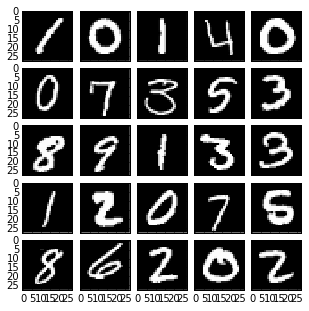

In [4]:
def get_digit(data, dig_index):
    digit_grid = np.reshape(data[dig_index], (28, 28))
    
    return digit_grid


fig = plt.figure(1, (5., 5.))

imgrid = ImageGrid(fig, 111,
                 nrows_ncols = (5, 5),  # creates 2x2 grid of axes
                 axes_pad = 0.1,  # pad between axes in inch.
                 )
for i in range(25):
    ax = imgrid[i].imshow(get_digit(train_x, i), cmap = cm.Greys_r, interpolation='none')  # The AxesGrid object work as a list of axes.

Let's look at the distribution of numbers.

[<matplotlib.text.Text at 0x1030e8f10>, <matplotlib.text.Text at 0x10d11b5d0>]

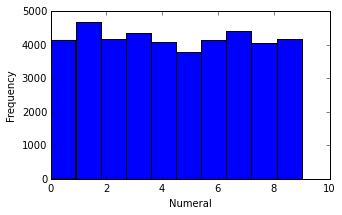

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(train_y, bins = 10)
ax.set(xlabel = 'Numeral', ylabel = 'Frequency')

So they're fairly evenly distributed. The labels are a bit off here... Fewer 5s than other things.

Next, let's look at the intensity distributions.

[<matplotlib.text.Text at 0x10d4e6650>, <matplotlib.text.Text at 0x10d4fb4d0>]

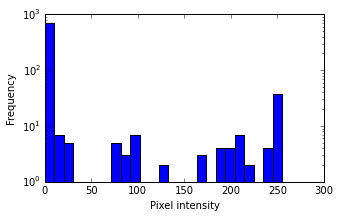

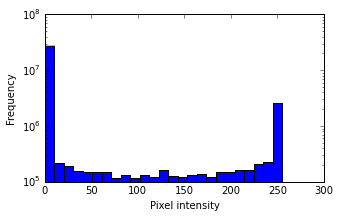

In [6]:
# single numeral:
example_num = train_x[0,:]
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(example_num, bins = 25, log=True)
ax.set(xlabel = 'Pixel intensity', ylabel = 'Frequency')

# all of the training data:
all_nums = np.reshape(train_x, -1)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(all_nums, bins = 25, log=True)
ax.set(xlabel = 'Pixel intensity', ylabel = 'Frequency')

Next, look at correlations between pixels and numerals. Need a measure of similarity betwen all 8's, for example.

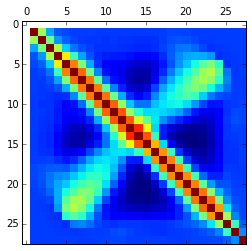

In [7]:
# First, look at the correlation matrix for the pixels.
# Convert the training x data into a dataframe, and use the correlation command.
pix_corr = pd.DataFrame(train_x[:,392:420]).corr(method='pearson')
plt.matshow(pix_corr)

This is the correlation matrix for the center row of pixels. The thickness of the diagonal should be the thickness of the pen. The anti-diagonal strip says something about the reflection symmetry of the numbers. We would expect this kind of result for numbers like "0".

Next, find the average image of each number.

(10, 784)


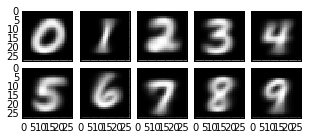

In [8]:
mean_numerals = train.groupby('label').mean().values

print mean_numerals.shape


fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,
                 nrows_ncols = (2, 5),  # creates 2x2 grid of axes
                 axes_pad = 0.1,  # pad between axes in inch.
                 )
for i in range(10):
    grid[i].imshow(get_digit(mean_numerals, i), cmap = cm.Greys_r, interpolation='none')


This shows the average of each number image. Here is the variance:

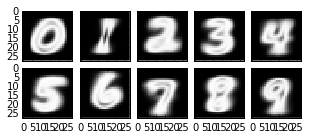

In [13]:
var_numerals = train.groupby('label').var().values

fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,
                 nrows_ncols = (2, 5),  # creates 2x2 grid of axes
                 axes_pad = 0.1,  # pad between axes in inch.
                 )
for i in range(10):
    grid[i].imshow(get_digit(var_numerals, i), cmap = cm.Greys_r, interpolation='none')

So we see that the variance is concentrated at the edges. No surprise there. Now, what's the average and variance over all of the numerals?

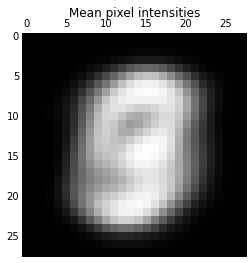

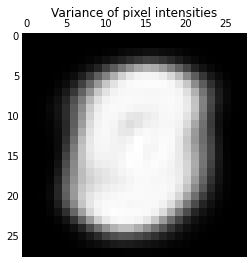

In [54]:
all_numeral_mean = np.reshape(train_x.mean(axis=0), (28, 28))
all_numeral_var = np.reshape(train_x.var(axis=0), (28, 28))

plt.matshow(all_numeral_mean, cmap = cm.Greys_r)
plt.title('Mean pixel intensities')

plt.matshow(all_numeral_var, cmap = cm.Greys_r)
plt.title('Variance of pixel intensities')

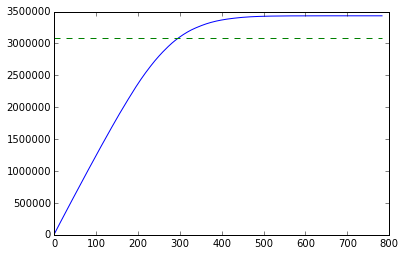

In [141]:
# generate a cumulative variance graph.

# order the pixels by variance
var_ordered = np.sort(train_x.var(axis=0))[::-1]

# create the cumulative vector by adding consecutive values
var_plot = []
cum_var = 0
for i in var_ordered:
    cum_var += i
    var_plot.append(cum_var)

plt.plot(var_plot)
# plot a line at the 90% point
a=np.empty(len(var_plot)); a.fill(0.9*np.max(cum_var))
plt.plot(a, '--')